In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline
from stable_baselines3 import PPO, A2C
from IPython.display import clear_output

In [3]:
import sys
sys.path.append(r"C:\Users\fidel\OneDrive\Documentos\Mestrado\code")
from RL_trading_envs import StockWithVolHold


In [4]:
def pnl_metric(y, yhat):
    return sum(y * yhat)

In [5]:
df = pd.read_pickle(r"D:\Datasets\TwoSigmaDataSetBr_2022_03_04\Papertrade_br\models\MlpVarianceSwap\trained_model\model_MlpVarianceSwap_2022-03-03\df_test_mestrado.pkl")

df.loc[:, 'volatility'] = df.groupby('asset_identifier')['t_minus_1'].apply(lambda x: x.rolling(35).std())

df                           = df[['asset_identifier', 'date', 'volatility', 'yhat', 'target']]
df                           = df.rename(columns = {'target': 'target_return'})
df.loc[:, 'realized_return'] = df.groupby("asset_identifier")['target_return'].shift(1)
df                           = df.dropna()

df.loc[:, 'date'] = df['date'].factorize()[0]
df.loc[:, 'asset_identifier'] = df['asset_identifier'].factorize()[0]

df.sort_values('date', inplace = True)
df.reset_index(drop = True, inplace = True)

In [6]:
assets = [0, 40]
df.query("asset_identifier.isin(@assets)", inplace = True, engine = 'python')
df.reset_index(drop = True, inplace = True)

# df.loc[:, 'target_return'] = 0
df.loc[:, 'realized_return'] = 0

df.head(4)

,asset_identifier,date,volatility,yhat,target_return,realized_return
0,0,0,0.013363,0.001609,0.009810,0
1,40,0,0.015805,0.001459,-0.011840,0
2,40,1,0.015933,0.001557,0.002496,0
3,0,1,0.014447,0.000885,-0.023429,0


In [9]:
df = df.drop(3).reset_index(drop = True)
df.head(4)

,asset_identifier,date,volatility,yhat,target_return,realized_return
0,0,0,0.013363,0.001609,0.009810,0
1,40,0,0.015805,0.001459,-0.011840,0
2,40,1,0.015933,0.001557,0.002496,0
3,40,2,0.015971,0.001590,0.005976,0


In [17]:
env = StockWithVolHold(df)

In [18]:
env.state_to_features(True)

{'portfolio_volatility': 0.0,
 'stock_volatility': 0.013363398305857985,
 'stock_prediction': 0.001608795952051878,
 'available_notional': 1.0,
 'stock_notional': 0.0}

In [19]:
%%time
action = np.array([0.1])
_, reward, _, _ = env.step(action)
print(f'reward / 30: {reward/30}')
print(env.state_to_features(True))

reward / 30: 0.0009809613227844238
{'portfolio_volatility': 0.0013363398305857987, 'stock_volatility': 0.01580520651208783, 'stock_prediction': 0.001459359540604055, 'available_notional': 0.9, 'stock_notional': 0.0}
Wall time: 0 ns


In [26]:
action = np.array([0.1])
_, reward, _, _ = env.step(action)
print(f'reward / 30: {reward/30}')
print(env.state_to_features(True))

NEW DAY ! $ &  ( # )
reward / 30: 0.0006436586380004883
{'portfolio_volatility': 0.004942194855373318, 'stock_volatility': 0.015727557236542563, 'stock_prediction': 0.0015094154514372349, 'available_notional': 0.6, 'stock_notional': 0.30000000000000004}


In [27]:
env.hidden_state

{0: [0.1, 0.014707973660207135],
 40: [0.30000000000000004, 0.015727557236542563]}

In [14]:
env.state_to_features(True)

{'portfolio_volatility': 0.0021507644088491693,
 'stock_volatility': 0.015933122886911705,
 'stock_prediction': 0.0015570971881970763,
 'available_notional': 0.8,
 'stock_notional': 0.1}

In [17]:
action = np.array([1.2])
_, reward, _, _ = env.step(action)
print(f'reward / 30: {reward/30}')
print(env.state_to_features(True))

reward / 30: 0.0022466182708740234
{'portfolio_volatility': 0.014412401308800555, 'stock_volatility': 0.01444694948104277, 'stock_prediction': 0.0008845236734487116, 'available_notional': 0.0, 'stock_notional': 0.1}


In [20]:
((0.9*0.015933122886911705)**2 + (0.1*0.01444694948104277)**2)**0.5

0.014412401308800556

In [18]:
env.hidden_state

{0: [0.1, 0.01444694948104277], 40: [0.9, 0.015933122886911705]}

In [27]:
def bound_allocation(allocation, available_notional, initial_stock_notional):
    initial_available_notional = available_notional
    if (available_notional <= 0) and (allocation * initial_stock_notional > 0):#There is no available notional and you are trying to increase position
        stock_notional = initial_stock_notional
    else:
        available_notional = available_notional + np.abs(initial_stock_notional) #Take off the asset from the portfolio
        stock_notional     = initial_stock_notional + allocation #Calculate the desired new notional
        #Clip this new notional
        if available_notional > 0:
            stock_notional = min(available_notional, max(stock_notional, -available_notional)) 
        elif allocation * initial_stock_notional > 0: #There is no available notional and you are trying to increase position
            stock_notional = initial_stock_notional
        else: #There is no available notional and you are trying to reduce your position
            if initial_stock_notional > 0:
                stock_notional = max(0, stock_notional)
            elif initial_stock_notional < 0:
                stock_notional = min(0, stock_notional)
            else:
                stock_notional = 0
    available_notional = initial_available_notional + np.abs(initial_stock_notional) - np.abs(stock_notional)
    allocation         = stock_notional - initial_stock_notional
    return allocation, available_notional, stock_notional

In [47]:
bound_allocation(allocation = -0.12, available_notional = 0, initial_stock_notional = -0.03)

(0.0, 0.0, -0.03)

In [17]:
env.rl_timestamp = 300

In [18]:
env.update_hidden_state_new_day()

(0.012190959909850186, -0.006382715702056951)

In [13]:
env.hidden_state#[0][1]

{0: [0.1, 0.013363398305857985],
 40: [0.1, 0.01580520651208783],
 138: [0.8, 0.01482872541930914],
 204: [0, 0.014200607574125298],
 41: [0, 0.018580996467913814],
 108: [0, 0.013001437228965412],
 42: [0, 0.021455110979965594],
 104: [0, 0.012131499826266125],
 139: [0, 0.012165580870885536],
 39: [0, 0.009731890992653498],
 199: [0, 0.02615744249536586],
 103: [0, 0.01988824297394862],
 142: [0, 0.013920923026839815],
 197: [0, 0.014358498105275598],
 46: [0, 0.05980510272573136],
 50: [0, 0.01521849163741122],
 52: [0, 0.014717138294185462],
 98: [0, 0.028463126677311885],
 97: [0, 0.013929304421699847],
 43: [0, 0.02254693140370819],
 143: [0, 0.01726278620658728],
 137: [0, 0.02949189627542225],
 37: [0, 0.019207619422299524],
 23: [0, 0.019493193114703333],
 121: [0, 0.01132499820431063],
 118: [0, 0.06614203585771357],
 132: [0, 0.015079577004716389],
 222: [0, 0.014095741143120899],
 24: [0, 0.013919419917205881],
 133: [0, 0.06842613597318865],
 215: [0, 0.014787612260796706]

In [206]:
(0.01444694948104277**2 + 0.015933122886911705**2)**0.5

0.02150764408849169

In [178]:
action = np.array([0.2])
_, reward, _, _ = env.step(action)
print(f'reward / 30: {reward/30}')
print(env.state_to_features(True))

NEW DAY ! $ &  ( # )
reward / 30: -0.007051586181236757
{'portfolio_volatility': 0.004443953822581824, 'stock_volatility': 0.015971041877426855, 'stock_prediction': 0.001590329804457724, 'available_notional': 0.6070079666891814, 'stock_notional': 0.0990626581692709}


In [179]:
env.hidden_state#[0][1]

{0: [0.2939293751415477, 0.014128494477478385],
 40: [0.0990626581692709, 0.015971041877426855]}

In [13]:
# agent_parameters = dict(learning_rate=0.0003,
#                         n_steps=2048,
#                         batch_size=64,
#                         n_epochs=10)
# agent_parameters = dict(learning_rate=0.0003,
#                         n_steps=2048,
#                         batch_size=2048,
#                         n_epochs=1)
agent_parameters = {}
def fit_rl(df_valid, agent_parameters):
    env   = StockWithVolHold(df_valid)
    model = PPO('MlpPolicy', env, verbose=0, **agent_parameters)
    list_results = []
    for i in range(30):
        clear_output(wait=True)
        model.learn(total_timesteps=len(df_valid))
        yhat = get_actions(df_valid, model).reshape(-1)
        list_results.append(pnl_metric(y, yhat))
        plt.plot(list_results)
        plt.show()
        plt.hist(yhat)
        plt.show()
        print(i)
    return model


In [14]:
%matplotlib inline

In [20]:
%%time
model = fit_rl(df_valid, agent_parameters)

0.0 0.0 0.013363398305857985
0.005425445566628439 0.40599295496940613 0.01580520651208783
0.008740837219692125 1.0 0.01482872541930914


C:\Users\fidel\OneDrive\Documentos\Mestrado\code\RL_trading_envs.py:507: RuntimeWarning: invalid value encountered in double_scalars
  vol_reward = -10 * (portfolio_volatility > 0.1) #Just guessing a volatility threshold
C:\Users\fidel\OneDrive\Documentos\Mestrado\code\RL_trading_envs.py:527: RuntimeWarning: invalid value encountered in double_scalars
  new_portfolio_volatility = (portfolio_volatility ** 2 - (initial_stock_notional * stock_volatility)**2 + (allocation * stock_volatility)**2) **0.5


ValueError: Expected parameter loc (Tensor of shape (1, 1)) of distribution Normal(loc: tensor([[nan]]), scale: tensor([[1.]])) to satisfy the constraint Real(), but found invalid values:
tensor([[nan]])

In [21]:
%%time
yhat = get_actions(df_valid, model).reshape(-1)

Wall time: 40 s


In [22]:
np.corrcoef(df_valid['target_return'].values, yhat)

array([[1.        , 0.00390731],
       [0.00390731, 1.        ]])

In [23]:
np.corrcoef(df_valid['yhat'].values, yhat)

array([[1.       , 0.7496184],
       [0.7496184, 1.       ]])

In [24]:
df_valid.shape

(134551, 5)

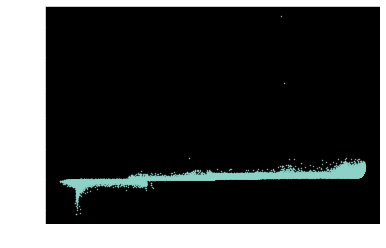

In [25]:
plt.scatter(yhat, df_valid['yhat'].values, s = 0.2)

In [32]:
df_valid.loc[:, 'pnl'] = yhat * df_valid['target_return']
df_valid.loc[:, 'pnl_naive'] = np.mean(yhat) * df_valid['target_return']

In [33]:
pnl = df_valid.groupby('date')['pnl'].sum()
pnl_naive = df_valid.groupby('date')['pnl_naive'].sum()

<AxesSubplot:xlabel='date'>

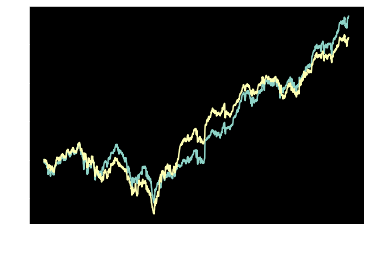

In [34]:
pnl.cumsum().plot()
pnl_naive.cumsum().plot()

In [35]:
df_valid = df_test

In [36]:
%%time
yhat = get_actions(df_valid, model).reshape(-1)

Wall time: 1min 3s


In [37]:
np.corrcoef(df_valid['target_return'].values, yhat)

array([[1.        , 0.01157254],
       [0.01157254, 1.        ]])

In [38]:
np.corrcoef(df_valid['yhat'].values, yhat)

array([[1.        , 0.73667683],
       [0.73667683, 1.        ]])

In [39]:
df_valid.shape

(200714, 5)

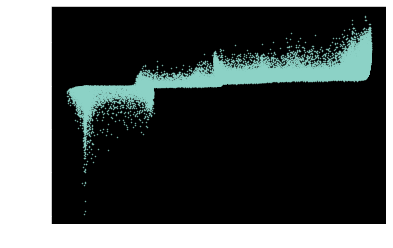

In [40]:
plt.scatter(yhat, df_valid['yhat'].values, s = 0.2)

In [41]:
df_valid.loc[:, 'pnl'] = yhat * df_valid['target_return']
df_valid.loc[:, 'pnl_naive'] = np.mean(yhat) * df_valid['target_return']

In [42]:
pnl = df_valid.groupby('date')['pnl'].sum()
pnl_naive = df_valid.groupby('date')['pnl_naive'].sum()

<AxesSubplot:xlabel='date'>

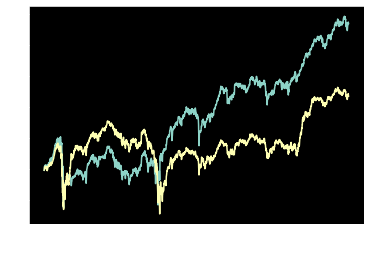

In [43]:
pnl.cumsum().plot()
pnl_naive.cumsum().plot()

<AxesSubplot:xlabel='date'>

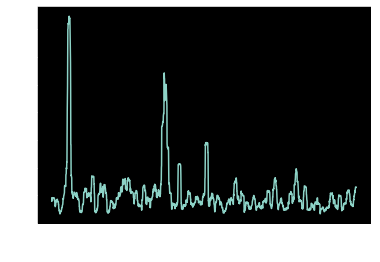

In [44]:
pnl.rolling(20).std().plot()

In [23]:
pnl_metric(y = df_valid['target_return'], yhat = yhat)

92.759

In [26]:
pnl_metric(y = df_valid['target_return'], yhat = 2*((df_valid['yhat'] > 0 )-0.5))

96.1021471619606